In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
import os
#from google.colab import drive
#from fbprophet.plot import add_changepoints_to_plot
#drive.mount('/content/drive')

Mounted at /content/drive


# PART 1 #
The following code calculates SARIMA with and without exogenous regressors for each district in Odisha


In [ ]:
def one_step_forecast(data, n_test, reg, model_autoarima):
  train, test = data.iloc[0:n_test], data.iloc[n_test:]
  if reg == True:
    exogP = ['Precipitation', 'peak_precip', 'Max_Temp', 'Min_Temp']
    train, test = data.iloc[0:n_test], data.iloc[n_test:]
    mod = sm.tsa.statespace.SARIMAX(endog=train[['Malaria_Cases']],order=(model_autoarima.order[0],model_autoarima.order[1],model_autoarima.order[2]),
                                      seasonal_order=(model_autoarima.seasonal_order[0],model_autoarima.seasonal_order[1],model_autoarima.seasonal_order[2],12),trend='c',exog=train[exogP],enforce_invertibility=False,enforce_stationarity=False)
    mod = mod.fit(maxiter=1000, disp=False, method='powell')
    forecast = mod.forecast(exog=test[exogP].iloc[0])
  else:
    mod = sm.tsa.statespace.SARIMAX(endog=train[['Malaria_Cases']],order=(model_autoarima.order[0],model_autoarima.order[1],model_autoarima.order[2]),
                                    seasonal_order=(model_autoarima.seasonal_order[0],model_autoarima.seasonal_order[1],model_autoarima.seasonal_order[2],12),trend='c',enforce_invertibility=False,enforce_stationarity=False)
    mod = mod.fit(maxiter=1000, disp=False, method='powell')    
    forecast = mod.forecast()
  if forecast.iloc[0] < 0:
    forecast.iloc[0] = abs(forecast.iloc[0])
  if test.iloc[0][0]==0:
    return forecast.iloc[0]
  return (abs(test.iloc[0][0]-forecast.iloc[0])/test.iloc[0][0])*100

In [ ]:
def run_ABS(model_autoarima, reg):
  errs = []
  for i in range(60, 130):
    errs.append(one_step_forecast(df.iloc[i-60:i+1], 60, reg, model_autoarima))
  return errs
  

In [ ]:
#ifile = open('/content/drive/Shareddrives/ProjectX 2021/results/SARIMA_hyperparameters.csv', 'w')
ifile = open('./results/SARIMA_hyperparameters.csv', 'w')
ifile.write('state,order,seasonal_order'+'\n')

27

In [ ]:
#directory = '/content/drive/Shareddrives/ProjectX 2021/data/PROCESSED ODISHA MALARIA DATA'
directory = './data/PROCESSED ODISHA MALARIA DATA'
dic={}
dicR={}
for filename in os.listdir(directory): # looping through entire directory
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f.split('/')[-1].split('_')[0])
    #dir = '/content/drive/Shareddrives/ProjectX 2021/data/PROCESSED ODISHA MALARIA DATA'
    #opening dataframe
    df = pd.read_csv(directory+'/'+f.split('/')[-1],index_col=0)
    df["Month"] = df["Year"].astype(str) + '-' + df["Month"].astype(str)
    df.set_index('Month',inplace=True)
    df.index=pd.to_datetime(df.index)
    df.index = pd.DatetimeIndex(df.index.values,
                                  freq=df.index.inferred_freq) #formatting index
    df=df[['Malaria_Cases', 'Precipitation', 'Min_Temp', 'Max_Temp']]
    #setting up peak precipitation
    df['peak_precip']=0
    for i in range(0,11):
      indexP=df[['Precipitation']].iloc[i*12:(i*12)+11].idxmax()
      df.loc[indexP[0], 'peak_precip']=1
    #running auto arima to finetune parameters
    model_autoarima = pmdarima.auto_arima(df['Malaria_Cases'], seasonal=True,m=12)
    ifile.write(f.split('/')[-1].split('_')[0]+ ',' +str(model_autoarima.order).replace(',', ' ')+',' +str(model_autoarima.seasonal_order).replace(',', ' ')+'\n')
    #writing absolute accuracy
    dic[f.split('/')[-1].split('_')[0]]=run_ABS(model_autoarima, False)
    dicR[f.split('/')[-1].split('_')[0]]=run_ABS(model_autoarima, True)
df=pd.DataFrame(dic)
df.to_csv('/content/drive/Shareddrives/ProjectX 2021/results/SARIMA_results.csv', index=False)
df=pd.DataFrame(dicR)
df.to_csv('/content/drive/Shareddrives/ProjectX 2021/results/SARIMA_reg_results.csv', index=False)

In [ ]:
ifile.close()

# PART 2 #
Below is an SARIMA Model that forecasts malaria case predictions for the district Puri.

In [ ]:
#dir = '/content/drive/Shareddrives/ProjectX 2021/data/PROCESSED ODISHA MALARIA DATA'
dir = './data/PROCESSED ODISHA MALARIA DATA'
df = pd.read_csv(dir+'/Puri_Malaria_Weather_TS.csv',index_col=0)
df["Month"] = df["Year"].astype(str) + '-' + df["Month"].astype(str)
df.set_index('Month',inplace=True)
df.index=pd.to_datetime(df.index)
df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
df=df[['Malaria_Cases', 'Precipitation', 'Min_Temp', 'Max_Temp']]

In [ ]:
df.head()

,Malaria_Cases,Precipitation,Min_Temp,Max_Temp
2003-01-01,49.0,2,16.8,25.6
2003-02-01,29.0,22,20.7,28.2
2003-03-01,37.0,27,23.9,29.9
2003-04-01,51.0,2,26.7,32.2
2003-05-01,46.0,19,28.0,33.6


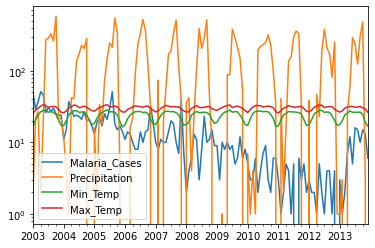

In [ ]:
df.plot(logy=True)

In [ ]:
df['peak_precip']=0

In [ ]:
for i in range(0,11):
  indexP=df[['Precipitation']].iloc[i*12:(i*12)+11].idxmax()
  df.loc[indexP[0], 'peak_precip']=1
  #df.loc[index[0], 'peak_precip']=df.loc[index[0], 'Malaria_Cases']

In [ ]:
model_autoarima = pmdarima.auto_arima(df['Malaria_Cases'], seasonal=True,m=12)

In [ ]:
errs = []
for i in range(0, 100):
  end = random.randint(60, 130)
  errs.append(one_step_forecast(df.iloc[end-60:end+1], 60))
  #print(str(i)+": " + str(errs[i]))

0: 25.96609804905331
1: 29.521613014496218
2: 59.30722264087783
3: 25.625233382375693
4: 85.39751165980537
5: 21.7917108080225
6: 59.30722264087783
7: 36.508684919727834
8: 96.65073442209292
9: 4.035217040600854
10: 12.261493384985112
11: 21.306663915343744
12: 22.62566873837676
13: 4.727943275329247
14: 4.727943275329247
15: 96.65073442209292
16: 4.035217040600854
17: 5.859990227607019
18: 4.126512503516138
19: 2.1626022861260914
20: 17.01936007354036
21: 12.106224505831362
22: 59.30722264087783
23: 44.5548210773309
24: 11.694998003258693
25: 98.50546105738954
26: 47.021706079936024
27: 52.192355640565594
28: 0.8695673082823904
29: 35.2913910986554
30: 5.859990227607019
31: 34.004991627859894
32: 43.197991260587116
33: 14.899905026323058
34: 8.904950720793856
35: 85.39751165980537
36: 5.173021368056116
37: 16.65418915878312
38: 39.899693773013176
39: 21.08091697912359
40: 9.64871980242766
41: 3.9452093500804675
42: 17.01936007354036
43: 60.14160163097198
44: 5.429860707930125
45: 20.5

In [ ]:
sum = 0
for i in errs:
  sum += i
print(sum/len(errs))

31.16338970905624


In [ ]:
def one_step_forecast(data, n_test):
    exogP = ['Precipitation',  'Max_Temp', 'Min_Temp']
    train, test = data.iloc[0:n_test], data.iloc[n_test:]
    #print(train.head())
    #print(test.head())
    mod = sm.tsa.statespace.SARIMAX(endog=train[['Malaria_Cases']],order=(model_autoarima.order[0],model_autoarima.order[1],model_autoarima.order[2]),
                                    seasonal_order=(model_autoarima.seasonal_order[0],model_autoarima.seasonal_order[1],model_autoarima.seasonal_order[2],12),trend='c',exog=train[exogP],enforce_invertibility=False,enforce_stationarity=False)
    mod = mod.fit(maxiter=1000, disp=False)    
    residuals = pd.DataFrame(mod.resid)
    #print(test[exogP].iloc[0])
    forecast = mod.forecast(exog=test[exogP].iloc[0])
    #forecast = mod.forecast()
    #print(forecast.head())
    #print('expected: '+ str(test.iloc[0][0])+ '  results: '+ str(forecast.iloc[0]))
    if forecast.iloc[0] < 0:
      forecast.iloc[0] = abs(forecast.iloc[0])
    print(forecast.iloc[0])
    if test.iloc[0][0]==0:
      return forecast.iloc[0]
    return (abs(test.iloc[0][0]-forecast.iloc[0])/test.iloc[0][0])*100

In [ ]:
errs = []
for i in range(0, 100):
  end = random.randint(60, 130)
  errs.append(one_step_forecast(df.iloc[end-60:end+1], 60))
  print(str(i)+": " + str(errs[i]))

7.963456258311879
0: 165.4485419437293
5.973986553370384
1: 19.479731067407684
10.345440332698587
2: 29.318004158732336
2.5207269523328417
3: 2.5207269523328417
10.369652004807296
4: 30.86898663461802
7.2650083624878405
5: 3.7858337498262937
1.8598615199956683
6: 85.98615199956683
2.5207269523328417
7: 2.5207269523328417
4.960471949139702
8: 396.0471949139702
0.2579151656349836
9: 97.13427593738906
1.2634125271621706
10: 57.88624909459431
1.503019377224824
11: 24.849031138758804
2.3482733016166577
12: 53.03453396766684
2.5207269523328417
13: 2.5207269523328417
5.114516425877071
14: 14.75805956871549
10.345440332698587
15: 29.318004158732336
3.562341587133446
16: 40.627640214442565
0.8981376488894242
17: 77.5465587777644
0.42884466545971556
18: 96.42629445450237
0.42884466545971556
19: 96.42629445450237
5.733063941533537
20: 42.66936058466463
0.2579151656349836
21: 97.13427593738906
6.609565164696873
22: 33.904348353031274
1.7835193668687293
23: 74.5211519018753
0.7651029881966025
24: 7

In [ ]:
errs.sort()
print(errs[int(len(errs)/2)])

42.66936058466463
